
# Movie Recommender | Content based

In [ ]:
!pip install lxml 

Installing dependencies and import libraries

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install requests

In [ ]:
import pandas as pd
from ast import literal_eval
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [ ]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv', encoding='utf-8')

The 5000 movie dataset from kaggle

In [ ]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [ ]:
movies.drop(columns ='title', inplace=True)

Coresponding credits dataset

In [ ]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
credits.rename(columns={'movie_id':'id'}, inplace=True)

Merging both based on the feature "title"

In [ ]:
df = movies.merge(credits, on='id')

In [ ]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
print('movies >>', movies.shape)
print('credits >>', credits.shape)
print('merged >>', df.shape)

movies >> (4803, 19)
credits >> (4803, 4)
merged >> (4803, 22)


In [ ]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
vote_average            float64
vote_count                int64
title                    object
cast                     object
crew                     object
dtype: object

In [ ]:
data = df[['id','title','genres','keywords','overview','release_date','cast','crew']]
data.head(2)

,id,title,genres,keywords,overview,release_date,cast,crew
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",2009-12-10,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",2007-05-19,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [ ]:
data.isnull().sum()

id              0
title           0
genres          0
keywords        0
overview        3
release_date    1
cast            0
crew            0
dtype: int64

> only 4 rows are having null values, hence will drop NaN

In [ ]:
data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.shape

(4799, 8)

In [ ]:
data['crew'].iloc[1]

'[{"credit_id": "52fe4232c3a36847f800b579", "department": "Camera", "gender": 2, "id": 120, "job": "Director of Photography", "name": "Dariusz Wolski"}, {"credit_id": "52fe4232c3a36847f800b4fd", "department": "Directing", "gender": 2, "id": 1704, "job": "Director", "name": "Gore Verbinski"}, {"credit_id": "52fe4232c3a36847f800b54f", "department": "Production", "gender": 2, "id": 770, "job": "Producer", "name": "Jerry Bruckheimer"}, {"credit_id": "52fe4232c3a36847f800b503", "department": "Writing", "gender": 2, "id": 1705, "job": "Screenplay", "name": "Ted Elliott"}, {"credit_id": "52fe4232c3a36847f800b509", "department": "Writing", "gender": 2, "id": 1706, "job": "Screenplay", "name": "Terry Rossio"}, {"credit_id": "52fe4232c3a36847f800b57f", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "52fe4232c3a36847f800b585", "department": "Editing", "gender": 2, "id": 1722, "job": "Editor", "name": "Craig Wood"}, {"credit_id": "52f

As the contents in the crew and cast columns are in a weird list and dict format, need to extract the tags.

> Will fetch the director name and top3 cast of each movie

In [ ]:

def convert_tags(obj):
  tags = []
  for i in literal_eval(obj):
    tags.append(i['name'])
  return tags


def convert_tags_top3(obj):
  tags = []
  counter = 0
  for i in literal_eval(obj):
    if counter !=3:
      tags.append(i['name'])
      counter+=1
    else:
      break   
  return tags

def fetch_director(obj):
  director = []
  for i in literal_eval(obj):
    if i['job']=='Director':
      director.append(i['name'])
  return director
  

In [ ]:
data['genres']= data['genres'].apply(convert_tags)
data['keywords']= data['keywords'].apply(convert_tags)
data['cast']= data['cast'].apply(convert_tags_top3)
data['crew']= data['crew'].apply(fetch_director)
data.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,id,title,genres,keywords,overview,release_date,cast,crew
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","In the 22nd century, a paraplegic Marine is di...",2009-12-10,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","Captain Barbossa, long believed to be dead, ha...",2007-05-19,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]


> The overview feature has a sentence of str type. Need to split each words as tokens

In [ ]:
data['overview'] = data['overview'].apply(lambda x : x.split())
data.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,genres,keywords,overview,release_date,cast,crew
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[In, the, 22nd, century,, a, paraplegic, Marin...",2009-12-10,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Captain, Barbossa,, long, believed, to, be, d...",2007-05-19,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]


> Each name tags in cast and crew features have special meanings. 
The name "Johnny Depp" and "Johnny" are both not the same. could be different entity. 

> Its good to merge the name tags, by removing the space in between each tags helps not to lose the meaning

In [ ]:
data['crew'] = data['crew'].apply(lambda x: [i.replace(" ", "") for i in x])
data['cast_merge'] = data['cast'].apply(lambda x: [i.replace(" ", "") for i in x])
data['overview'] = data['overview'].apply(lambda x: [i.replace(" ", "") for i in x])
data['keywords'] = data['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
data['genres'] = data['genres'].apply(lambda x: [i.replace(" ", "") for i in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
data.head(2)

,id,title,genres,keywords,overview,release_date,cast,crew,cast_merge
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[In, the, 22nd, century,, a, paraplegic, Marin...",2009-12-10,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[JamesCameron],"[SamWorthington, ZoeSaldana, SigourneyWeaver]"
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[Captain, Barbossa,, long, believed, to, be, d...",2007-05-19,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[GoreVerbinski],"[JohnnyDepp, OrlandoBloom, KeiraKnightley]"


In [ ]:
data['tags'] = data['genres']+ data['keywords'] + data['overview']+data['cast_merge']+data['crew']
data.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,genres,keywords,overview,release_date,cast,crew,cast_merge,tags
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[In, the, 22nd, century,, a, paraplegic, Marin...",2009-12-10,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[JamesCameron],"[SamWorthington, ZoeSaldana, SigourneyWeaver]","[Action, Adventure, Fantasy, ScienceFiction, c..."
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[Captain, Barbossa,, long, believed, to, be, d...",2007-05-19,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[GoreVerbinski],"[JohnnyDepp, OrlandoBloom, KeiraKnightley]","[Adventure, Fantasy, Action, ocean, drugabuse,..."


> we only require the movie title and its corresponding tags to recommend the similar movies

In [ ]:
old_data = data[['title', 'tags']]
old_data.head(2)

,title,tags
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction, c..."
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action, ocean, drugabuse,..."


In [ ]:
old_data['tags'] = old_data['tags'].apply(lambda x:' '.join(x))
old_data['tags'] = old_data['tags'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
old_data.head(2)

,title,tags
0,Avatar,action adventure fantasy sciencefiction cultur...
1,Pirates of the Caribbean: At World's End,adventure fantasy action ocean drugabuse exoti...


In [ ]:
old_data.shape

(4799, 2)

In [ ]:
#old_data.to_csv('movie_data2.csv', index=False)

> stemming helps to retain the important str in words. makes the tags shorter and not simmilar

In [ ]:
stemmer = PorterStemmer()
stemmer.stem('loving')

'love'

> Need to preprocess the tags to remove stopwords and apply stemming for all the tags


In [ ]:
import string 
string.punctuation
def word_preprocessor(obj):
  txt = "".join([c for c in obj if c not in string.punctuation])
  words = txt.split()
  new_words =[]

  for word in words:
    if word not in set(stopwords.words('english')): 
      new_words.append(stemmer.stem(word))
  return " ".join(new_words)

word_preprocessor(old_data['tags'][0])

'action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d 22nd centuri parapleg marin dispatch moon pandora uniqu mission becom torn follow order protect alien civil samworthington zoesaldana sigourneyweav jamescameron'

In [ ]:
old_data['tags'] = old_data['tags'].apply(word_preprocessor)
old_data.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,title,tags
0,Avatar,action adventur fantasi sciencefict culturecla...
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exotici...


> saving the dataset as csv movie _data1

In [ ]:
old_data.to_csv('movie_data1.csv', index=False)

# New data processing


The 5000 movie kaggle dataset might only contain popular old movies till 2017(might be). we can webscrap all the most resent english movies and even unrealased movies from wiki 

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2018"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]

In [ ]:
eng_movies_2018 = df1.append(df2.append(df3.append(df4,ignore_index=True),ignore_index=True),ignore_index=True)
eng_movies_2018.drop(columns='.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.', inplace=True)
eng_movies_2018['Year'] = '2018'
eng_movies_2018 = eng_movies_2018[['Title','Cast and crew','Year']]

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2019"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]
eng_movies_2019 = df1.append(df2.append(df3.append(df4,ignore_index=True),ignore_index=True),ignore_index=True)
eng_movies_2019['Year'] = '2019'
eng_movies_2019 = eng_movies_2019[['Title','Cast and crew','Year']]

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2020"
df1 = pd.read_html(link, header=0)[2]
df2 = pd.read_html(link, header=0)[3]
df3 = pd.read_html(link, header=0)[4]
df4 = pd.read_html(link, header=0)[5]
eng_movies_2020 = df1.append(df2.append(df3.append(df4,ignore_index=True),ignore_index=True),ignore_index=True)
eng_movies_2020.drop(columns='.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.', inplace=True)
eng_movies_2020['Year'] = '2020'
eng_movies_2020 = eng_movies_2020[['Title','Cast and crew','Year']]

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2021"
df1 = pd.read_html(link, header=0)[3]
df2 = pd.read_html(link, header=0)[4]
df3 = pd.read_html(link, header=0)[5]
df4 = pd.read_html(link, header=0)[6]
eng_movies_2021 = df1.append(df2.append(df3.append(df4,ignore_index=True),ignore_index=True),ignore_index=True)
eng_movies_2021.drop(columns='.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.', inplace=True)
eng_movies_2021['Year'] = '2021'
eng_movies_2021 = eng_movies_2021[['Title','Cast and crew','Year']]

In [ ]:
link = "https://en.wikipedia.org/wiki/List_of_American_films_of_2022"
df1 = pd.read_html(link, header=0)[3]
df2 = pd.read_html(link, header=0)[4]
df3 = pd.read_html(link, header=0)[5]
df4 = pd.read_html(link, header=0)[6]
eng_movies_2022 = df1.append(df2.append(df3.append(df4,ignore_index=True),ignore_index=True),ignore_index=True)
eng_movies_2022.drop(columns='.mw-parser-output .tooltip-dotted{border-bottom:1px dotted;cursor:help}Ref.', inplace=True)
eng_movies_2022['Year'] = '2022'
eng_movies_2022 = eng_movies_2022[['Title','Cast and crew','Year']]

eng_movies_2022.dropna(inplace=True)

we have now webscrapped and stored the data in pandas df 
(2018-2022)

> The moviedatabase API TBDB v3 helps to fetch nessary data related to movied

In [ ]:
!pip install tmdbv3api

In [ ]:
from tmdbv3api import TMDb
from tmdbv3api import Movie
import json
import requests


tmdb = TMDb()
tmdb.api_key="12aee6e6e9db1d19c5d8078b2188e3a6"
tmdb_movie = Movie()

> Using the tmdb api fetching the genre all the movies in the dataset

In [ ]:
import numpy as np
def get_genre(title):
  info=[]
  result = tmdb_movie.search(title)
  if result:
    movie_id = result[0].id
  else:
    return np.NaN
  response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
  data_json = response.json()
  if data_json['genres']:
    obj = data_json['genres']
    tags=[]
    for i in literal_eval(str(obj)):
      tags.append(i['name'])
    return tags

  else:
    return np.NaN

> fetching overview from API

In [ ]:
def get_overview(title):
  info=[]
  result = tmdb_movie.search(title)
  if result:
    movie_id = result[0].id
  else:
    return np.NaN
  response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
  data_json = response.json()
  if data_json['overview']:
    overview = data_json['overview']
    return overview
  else:
    return np.NaN

In [ ]:
get_genre('Minions: The Rise of Gru')

['Family', 'Animation', 'Action', 'Adventure', 'Comedy']

In [ ]:
#eng_movies_2022['genre'] = eng_movies_2022['Title'].apply(get_genre)

In [ ]:
eng_movies_2022.shape

(115, 3)

In [ ]:
eng_movies_2022

,Title,Cast and crew,Year
0,The 355,Simon Kinberg (director/screenplay); Theresa R...,2022
1,Scream,"Matt Bettinelli-Olpin, Tyler Gillett (director...",2022
2,Hotel Transylvania: Transformania,"Jennifer Kluska, Derek Drymon (directors); Amo...",2022
3,Shattered,Luis Prieto (director); David Loughery (screen...,2022
4,The Royal Treatment,Rick Jacobson (director); Holly Hester (screen...,2022
...,...,...,...
112,Avatar 2,James Cameron (director/screenplay); Josh Frie...,2022
113,Aquaman and the Lost Kingdom,"James Wan (director), David Leslie Johnson-McG...",2022
114,Untitled Mario film,"Aaron Horvath, Michael Jelenic (directors); Ma...",2022
115,I Wanna Dance with Somebody,Kasi Lemmons (director); Anthony McCarten (scr...,2022


In [ ]:
eng_movies_2018['genre'] = eng_movies_2018['Title'].apply(get_genre)
eng_movies_2019['genre'] = eng_movies_2019['Title'].apply(get_genre)
eng_movies_2020['genre'] = eng_movies_2020['Title'].apply(get_genre)
eng_movies_2021['genre'] = eng_movies_2021['Title'].apply(get_genre)
eng_movies_2022['genre'] = eng_movies_2022['Title'].apply(get_genre)

In [ ]:
eng_movies_2018['overview'] = eng_movies_2018['Title'].apply(get_overview)
eng_movies_2019['overview'] = eng_movies_2019['Title'].apply(get_overview)
eng_movies_2020['overview'] = eng_movies_2020['Title'].apply(get_overview)
eng_movies_2021['overview'] = eng_movies_2021['Title'].apply(get_overview)
eng_movies_2022['overview'] = eng_movies_2022['Title'].apply(get_overview)

> combining the dataset

In [ ]:
combined_data = eng_movies_2018.append(eng_movies_2019,ignore_index=True)
combined_data = combined_data.append(eng_movies_2020,ignore_index=True)
combined_data = combined_data.append(eng_movies_2021,ignore_index=True)
combined_data = combined_data.append(eng_movies_2022,ignore_index=True)

In [ ]:
combined_data.head(2)

,Title,Cast and crew,Year,genre,overview
0,Insidious: The Last Key,Adam Robitel (director); Leigh Whannell (scree...,2018,"[Horror, Mystery, Thriller]",Parapsychologist Elise Rainier and her team tr...
1,The Strange Ones,Lauren Wolkstein (director); Christopher Radcl...,2018,"[Thriller, Drama]",Mysterious events surround the travels of two ...


In [ ]:
combined_data.shape

(1260, 5)

> the cast row is not in proper format, need to extract director name and top3 actors

In [ ]:
def get_director(x):
    if " (director)" in x:
        return x.split(" (director)")[0]
    elif " (directors)" in x:
        return x.split(" (directors)")[0]
    else:
        return x.split(" (director/screenplay)")[0]

def get_actor1(x):
    return ((x.split("screenplay); ")[-1]).split(", ")[0])

def get_actor2(x):
    if len((x.split("screenplay); ")[-1]).split(", ")) < 2:
        return np.NaN
    else:
        return ((x.split("screenplay); ")[-1]).split(", ")[1])

def get_actor3(x):
    if len((x.split("screenplay); ")[-1]).split(", ")) < 3:
        return np.NaN
    else:
        return ((x.split("screenplay); ")[-1]).split(", ")[2])


In [ ]:
combined_data['director'] = combined_data['Cast and crew'].apply(get_director)
combined_data['actor1'] = combined_data['Cast and crew'].apply(get_actor1)
combined_data['actor2'] = combined_data['Cast and crew'].apply(get_actor2)
combined_data['actor3'] = combined_data['Cast and crew'].apply(get_actor3)

In [ ]:
combined_data.drop(columns=['Cast and crew'], inplace=True)
combined_data.head(2)

,Title,Year,genre,overview,director,actor1,actor2,actor3,cast_seperated
0,Insidious: The Last Key,2018,"[Horror, Mystery, Thriller]",Parapsychologist Elise Rainier and her team tr...,Adam Robitel,Lin Shaye,Angus Sampson,Leigh Whannell,"[Lin Shaye, Angus Sampson, Leigh Whannell]"
1,The Strange Ones,2018,"[Thriller, Drama]",Mysterious events surround the travels of two ...,Lauren Wolkstein,Alex Pettyfer,James Freedson-Jackson,Emily Althaus,"[Alex Pettyfer, James Freedson-Jackson, Emily ..."


In [ ]:
combined_data.isnull().sum()

Title              0
Year               0
genre             10
overview           7
director           0
actor1             0
actor2             0
actor3             0
cast_seperated     0
dtype: int64

In [ ]:
combined_data.fillna('Unknown', inplace=True)

In [ ]:
combined_data.reset_index(inplace=True)
combined_data.drop(columns='index', inplace=True)

In [ ]:
combined_data.head()

,Title,Year,genre,overview,director,actor1,actor2,actor3
0,Insidious: The Last Key,2018,"[Horror, Mystery, Thriller]",Parapsychologist Elise Rainier and her team tr...,Adam Robitel,Lin Shaye,Angus Sampson,Leigh Whannell
1,The Strange Ones,2018,"[Thriller, Drama]",Mysterious events surround the travels of two ...,Lauren Wolkstein,Alex Pettyfer,James Freedson-Jackson,Emily Althaus
2,Stratton,2018,"[Action, Thriller]",A British Special Boat Service commando tracks...,Simon West,Dominic Cooper,Austin Stowell,Gemma Chan
3,Sweet Country,2018,"[Drama, History, Western]","It’s 1929 on the vast, desert-like, Eastern Ar...",Warwick Thornton,Bryan Brown,Sam Neill,Unknown
4,The Commuter,2018,"[Action, Thriller]","A businessman, on his daily commute home, gets...",Jaume Collet-Serra,Liam Neeson,Vera Farmiga,Patrick Wilson


In [ ]:
actors=""
for i in range(len(combined_data)):
#  actors = combined_data['actor1'][i].pop()
  print(i)

> found that the actor 2 and 3 features are in undiresed type. need to convert it to str

In [ ]:
combined_data['actor2'] = combined_data['actor2'].apply(lambda x: str(x))
combined_data['actor3'] = combined_data['actor3'].apply(lambda x: str(x))

>Combining the name tag to not miss its importances

In [ ]:
def wordcombine(obj):
  obj_list=[]
  splitted = obj.replace(' ', "")
  obj_list.append(splitted)
  return obj_list

In [ ]:
combined_data['director'] = combined_data['director'].apply(wordcombine)
combined_data['actor1'] = combined_data['actor1'].apply(wordcombine)
combined_data['actor2'] = combined_data['actor2'].apply(wordcombine)
combined_data['actor3'] = combined_data['actor3'].apply(wordcombine)
combined_data.head(2)

,Title,Year,genre,overview,director,actor1,actor2,actor3
0,Insidious: The Last Key,2018,"[Horror, Mystery, Thriller]",Parapsychologist Elise Rainier and her team tr...,[AdamRobitel],[LinShaye],[AngusSampson],[LeighWhannell]
1,The Strange Ones,2018,"[Thriller, Drama]",Mysterious events surround the travels of two ...,[LaurenWolkstein],[AlexPettyfer],[JamesFreedson-Jackson],[EmilyAlthaus]


> splitting the word in overview

In [ ]:
combined_data['overview'] = combined_data['overview'].apply(lambda x : str(x).split())
combined_data.head(2)

,Title,Year,genre,overview,director,actor1,actor2,actor3
0,Insidious: The Last Key,2018,"[Horror, Mystery, Thriller]","[Parapsychologist, Elise, Rainier, and, her, t...",[AdamRobitel],[LinShaye],[AngusSampson],[LeighWhannell]
1,The Strange Ones,2018,"[Thriller, Drama]","[Mysterious, events, surround, the, travels, o...",[LaurenWolkstein],[AlexPettyfer],[JamesFreedson-Jackson],[EmilyAlthaus]


In [ ]:
combined_data.isnull().sum()

Title       0
Year        0
genre       0
overview    0
director    0
actor1      0
actor2      0
actor3      0
dtype: int64

In [ ]:
combined_data=combined_data.reset_index()
combined_data.drop(columns='index', inplace=True)

In [ ]:
combined_data[25:27]

,Title,Year,genre,overview,director,actor1,actor2,actor3
25,La Boda de Valentina,2018,[Comedy],"[Valentina, seems, to, have, the, perfect, lif...",[MarcoPoloConstandse],[MarcoPoloConstandse(director);OmarChaparro],[MarimarVega],[RyanCarnes]
26,Kri,2018,Unknown,"[Kri-Kri, fools, his, friend, by, pretending, ...",[SurendraPoudel],[AnmolK.C.],[AditiBudhathoki],[AnoopBikramShahi]


In [ ]:
combined_data['director'] = combined_data['director'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['genre'] = combined_data['genre'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['overview'] = combined_data['overview'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['director'] = combined_data['director'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['actor1'] = combined_data['actor1'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['actor2'] = combined_data['actor2'].apply(lambda x: [i.replace(" ", "") for i in x])
combined_data['actor3'] = combined_data['actor3'].apply(lambda x: [i.replace(" ", "") for i in x])

In [ ]:
combined_data['tags'] = combined_data['genre'] + combined_data['overview'] + combined_data['director']+combined_data['actor1']+combined_data['actor2'] + combined_data['actor3']
combined_data.head(2)

,Title,Year,genre,overview,director,actor1,actor2,actor3,tags
0,Insidious: The Last Key,2018,"[Horror, Mystery, Thriller]","[Parapsychologist, Elise, Rainier, and, her, t...",[AdamRobitel],[LinShaye],[AngusSampson],[LeighWhannell],"[Horror, Mystery, Thriller, Parapsychologist, ..."
1,The Strange Ones,2018,"[Thriller, Drama]","[Mysterious, events, surround, the, travels, o...",[LaurenWolkstein],[AlexPettyfer],[JamesFreedson-Jackson],[EmilyAlthaus],"[Thriller, Drama, Mysterious, events, surround..."


In [ ]:
new_data = combined_data[['Title','tags']]
new_data.head(3)

,Title,tags
0,Insidious: The Last Key,"[Horror, Mystery, Thriller, Parapsychologist, ..."
1,The Strange Ones,"[Thriller, Drama, Mysterious, events, surround..."
2,Stratton,"[Action, Thriller, A, British, Special, Boat, ..."


Saved the dataset for merging both the data

In [ ]:
new_data = pd.read_csv('webscrapped_data.csv')
new_data

,Title,tags
0,Insidious: The Last Key,horror mystery thriller parapsychologist elise...
1,The Strange Ones,thriller drama mysterious events surround the ...
2,Stratton,action thriller a british special boat service...
3,Sweet Country,"drama history western it’s 1929 on the vast, d..."
4,The Commuter,"action thriller a businessman, on his daily co..."
...,...,...
1247,Violent Night,horror thriller a coal-dark holiday thriller t...
1248,Avatar 2,action adventure science fiction fantasy twelv...
1249,Aquaman and the Lost Kingdom,adventure action fantasy when an ancient power...
1250,I Wanna Dance with Somebody,drama biopic of the legendary singer whitney h...


In [ ]:
new_data.rename(columns={'Title':'title'}, inplace=True)
new_data.head(2)

,title,tags
0,Insidious: The Last Key,horror mystery thriller parapsychologist elise...
1,The Strange Ones,thriller drama mysterious events surround the ...


Applying the preprocessing to remove stopwords and punctuations

In [ ]:
import string 
string.punctuation
def word_preprocessor(obj):
  txt = "".join([c for c in obj if c not in string.punctuation])
  words = txt.split()
  new_words =[]

  for word in words:
    if word not in set(stopwords.words('english')): 
      new_words.append(stemmer.stem(word))
  return " ".join(new_words)

word_preprocessor(new_data['tags'][0])

'horror mysteri thriller parapsychologist elis rainier team travel five key nm investig man’ claim haunt terror soon strike rainier realiz hous live family’ old home adamrobitel linshay angussampson leighwhannel'

In [ ]:
new_data['tags'] = new_data['tags'].apply(word_preprocessor)

In [ ]:
new_data

,title,tags
0,Insidious: The Last Key,horror mysteri thriller parapsychologist elis ...
1,The Strange Ones,thriller drama mysteri event surround travel t...
2,Stratton,action thriller british special boat servic co...
3,Sweet Country,drama histori western it’ 1929 vast desertlik ...
4,The Commuter,action thriller businessman daili commut home ...
...,...,...
1247,Violent Night,horror thriller coaldark holiday thriller say ...
1248,Avatar 2,action adventur scienc fiction fantasi twelv y...
1249,Aquaman and the Lost Kingdom,adventur action fantasi ancient power unleash ...
1250,I Wanna Dance with Somebody,drama biopic legendari singer whitney houston ...


In [ ]:
print('Data 1 > ',old_data.shape)
print('Data 2 > ',new_data.shape)

Data 1 >  (4799, 2)
Data 2 >  (1252, 2)


>combining both the dataset

In [ ]:
final_df = old_data.append(new_data,ignore_index=True)
final_df.shape

(6051, 2)

In [ ]:
final_df

,title,tags
0,Avatar,action adventur fantasi sciencefict culturecla...
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exotici...
2,Spectre,action adventur crime spi basedonnovel secreta...
3,The Dark Knight Rises,action crime drama thriller dccomic crimefight...
4,John Carter,action adventur sciencefict basedonnovel mar m...
...,...,...
6046,Violent Night,horror thriller coaldark holiday thriller say ...
6047,Avatar 2,action adventur scienc fiction fantasi twelv y...
6048,Aquaman and the Lost Kingdom,adventur action fantasi ancient power unleash ...
6049,I Wanna Dance with Somebody,drama biopic legendari singer whitney houston ...


>droping the duplicates based on title

In [ ]:
final_df.drop_duplicates(subset ="title", keep = 'last', inplace = True)

In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
final_df.drop(columns=['index'], inplace=True)
final_df

,title,tags
0,Avatar,action adventur fantasi sciencefict culturecla...
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exotici...
2,Spectre,action adventur crime spi basedonnovel secreta...
3,The Dark Knight Rises,action crime drama thriller dccomic crimefight...
4,John Carter,action adventur sciencefict basedonnovel mar m...
...,...,...
5998,Violent Night,horror thriller coaldark holiday thriller say ...
5999,Avatar 2,action adventur scienc fiction fantasi twelv y...
6000,Aquaman and the Lost Kingdom,adventur action fantasi ancient power unleash ...
6001,I Wanna Dance with Somebody,drama biopic legendari singer whitney houston ...


In [ ]:
final_df.shape

(6003, 2)

In [ ]:
final_df.isnull().sum()

title    0
tags     0
dtype: int64

In [ ]:
final_df

,title,tags
0,Avatar,action adventur fantasi sciencefict culturecla...
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exotici...
2,Spectre,action adventur crime spi basedonnovel secreta...
3,The Dark Knight Rises,action crime drama thriller dccomic crimefight...
4,John Carter,action adventur sciencefict basedonnovel mar m...
...,...,...
5998,Violent Night,horror thriller a coal-dark holiday thriller t...
5999,Avatar 2,action adventure science fiction fantasy twelv...
6000,Aquaman and the Lost Kingdom,adventure action fantasy when an ancient power...
6001,I Wanna Dance with Somebody,drama biopic of the legendary singer whitney h...


>our dataset is now cleaning and set for model processing

#### converting the tags into vectors with max 7000 features (or else the vector would be very large for process)

In [ ]:
vectorizer = CountVectorizer(max_features=7000, stop_words='english')
new_tags = vectorizer.fit_transform(final_df['tags']).toarray()

In [ ]:
new_tags.shape

(6003, 7000)

> random vectors

In [ ]:
vectorizer.get_feature_names()[500:510]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['australia',
 'australian',
 'austria',
 'austrian',
 'authent',
 'author',
 'autism',
 'autist',
 'auto',
 'automaton']

>the vectorized tags

In [ ]:
new_tags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

>using cosine similarity we find the similarity score among the vectors

>Which means for a movie, the most scored similarity would be the recommended movies

In [ ]:
similarity = cosine_similarity(new_tags)

In [ ]:
similarity.shape

(6003, 6003)

The similarity metrics would be an array of 6003 * 6003 dim

In [ ]:
similarity

array([[1.        , 0.07845987, 0.07845987, ..., 0.14794534, 0.        ,
        0.07188852],
       [0.07845987, 1.        , 0.05882353, ..., 0.16637807, 0.        ,
        0.08084521],
       [0.07845987, 0.05882353, 1.        , ..., 0.08318903, 0.        ,
        0.12126781],
       ...,
       [0.14794534, 0.16637807, 0.08318903, ..., 1.        , 0.        ,
        0.11433239],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.07188852, 0.08084521, 0.12126781, ..., 0.11433239, 0.        ,
        1.        ]])

similarity for the 1st movie in the dataset

In [ ]:
similarity[0]

array([1.        , 0.07845987, 0.07845987, ..., 0.14794534, 0.        ,
       0.07188852])

In [ ]:
# new_data['title'] = new_data['title'].apply(lambda x : x.lower())

sortting and showing the top scored similarities

In [ ]:
similar = sorted(list(enumerate(similarity[0])),reverse=True, key=lambda x : x[1])[:10]

movie_list=[]
for i in similar:
  print(final_df['title'][i[0]])

Avatar
Aliens
Titan A.E.
Independence Day
Aliens vs Predator: Requiem
Meet Dave
Predators
Lifeforce
Ender's Game
Jupiter Ascending


The simialrity score will be in 0-1 and the coresponding index will be retained

In [ ]:
similar

[(0, 1.0000000000000002),
 (2385, 0.2614261205701794),
 (534, 0.23537960143467362),
 (502, 0.22874785549890703),
 (1202, 0.21892844799880407),
 (770, 0.2178551004751495),
 (1190, 0.21785510047514947),
 (1899, 0.20691022044226628),
 (259, 0.2062157048905868),
 (60, 0.20543854480931223)]

> Function to get the similar movie suggestions

In [ ]:
def recommender(movie):
  movie_index = final_df[final_df['title']==movie].index[0]
  similar_movies = sorted(list(enumerate(similarity[movie_index])),reverse=True, key=lambda x : x[1])[:10]
  movie_list=[]
  for i in similar_movies:
    print(final_df['title'][i[0]])
  
  return movie_list

recommender('Avatar 2')

Avatar 2
A.X.L.
Everything Everywhere All at Once
The King
Sonic the Hedgehog
Artemis Fowl
Trollhunters: Rise of the Titans
Black Panther: Wakanda Forever
Pacific Rim: Uprising
Spider-Man: Across the Spider-Verse (Part One)


[]

> Exporting the final dataset for the web APP

In [ ]:
final_df.to_csv('final_clean_data.csv', index=False)

A heatmap of the head(10) movies similarities

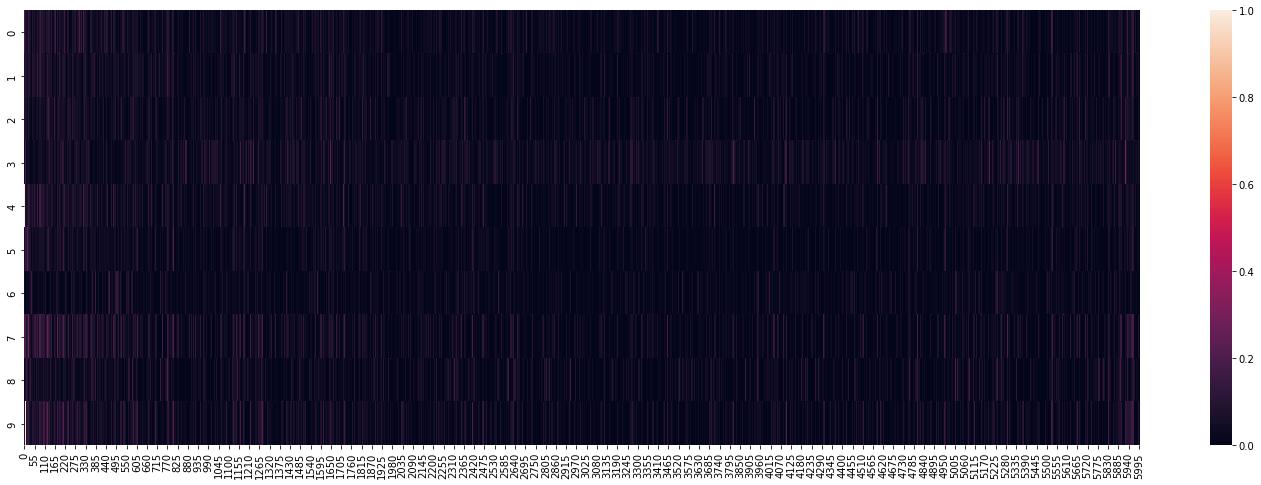

In [ ]:
cm = similarity[:10]
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
sns.heatmap(cm)

Dumping the pickle model for web API as movie recommender

In [ ]:
import pickle
pickle.dump(similarity, open('movie_recommender.pkl', 'wb'))

# Rough Area

> Practing the codes

In [ ]:
import requests

def fetch_poster(movie_id):
  response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
  data = response.json()
  return 'https://image.tmdb.org/t/p/original'+ data['poster_path']

In [ ]:
fetch_poster(285)

'https://image.tmdb.org/t/p/original/2YMnBRh8F6fDGCCEIPk9Hb0cEyB.jpg'

In [ ]:
cm = similarity[:10]
cm.shape

(10, 6003)

In [ ]:
movies_dict = pickle.load(open('Movies_dict.pkl', 'rb'))
pd.DataFrame(movies_dict)


,title,tags
0,Avatar,action adventur fantasi sciencefict culturecla...
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exotici...
2,Spectre,action adventur crime spi basedonnovel secreta...
3,The Dark Knight Rises,action crime drama thriller dccomic crimefight...
4,John Carter,action adventur sciencefict basedonnovel mar m...
...,...,...
4804,El Mariachi,action crime thriller unitedstates–mexicobarri...
4805,Newlyweds,comedi romanc newlyw couple' honeymoon upend a...
4806,"Signed, Sealed, Delivered",comedi drama romanc tvmovi date loveatfirstsig...
4807,Shanghai Calling,ambiti new york attorney sam sent shanghai ass...


In [ ]:
similarity

In [ ]:
!pip install tmdbv3api

In [ ]:
from tmdbv3api import TMDb
from tmdbv3api import Movie
import json
import requests
tmdb = TMDb()
tmdb.api_key="12aee6e6e9db1d19c5d8078b2188e3a6"
tmdb_movie = Movie()

In [ ]:
def get_info(x):
  info=[]
  result = tmdb_movie.search(x)
  movie_id = result[0].id
  response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
  data_json = response.json()
  return data_json

In [ ]:
get_info('Avatar 2')

In [ ]:
response = requests.get(f'https://api.themoviedb.org/3/movie/126186?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
response.json()

In [ ]:
import json
import bs4 as bs
import urllib.request
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_imdb_id(title):
  info=[]
  result = tmdb_movie.search(title)
  if result:
    movie_id = result[0].id
  else:
    return np.NaN
  response = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?api_key=12aee6e6e9db1d19c5d8078b2188e3a6')
  data_json = response.json()
  if data_json['imdb_id']:
    id = data_json['imdb_id']
    return id
  else:
    return np.NaN

In [ ]:
get_imdb_id('Avatar 2')

'tt1630029'

In [ ]:
def get_reviews(title):
  imdb_id = get_imdb_id(title)
  sauce = urllib.request.urlopen(f'https://www.imdb.com/title/{imdb_id}/reviews?ref_=tt_ov_rt').read()
  soup = bs.BeautifulSoup(sauce,'lxml')
  soup_result = soup.find_all("div",{"class":"text show-more__control"})
  reviews = []
  for i in range(len(soup_result)):
    reviews.append(soup_result[i].text)
  reviews_df = pd.DataFrame({'Reviews':reviews})
  return reviews_df



In [ ]:
get_reviews('Avatar')

,Reviews
0,"As of today, there are 2675 reviews for ""Avata..."
1,I did see Avatar for the first time a while ag...
2,It's impossible to watch AVATAR for the first ...
3,Avatar (2009) **** (out of 4)A paraplegic mari...
4,Marine Jake Sully (Sam Worthington) is paralyz...
5,"This is a remarkable experience, like watching..."
6,high technology. imaginative director. tastefu...
7,"""Avatar"" is an American movie from 2009 and st..."
8,"I've been badgered to see this film for years,..."
9,In a futuristic society ruled by the economica...


Images scrolling feature in streamlit

In [ ]:
import streamlit as st
import streamlit.components.v1 as components

def main():

    imageCarouselComponent = components.declare_component("image-carousel-component", path="frontend/public")

    imageUrls = [
        "https://images.unsplash.com/photo-1522093007474-d86e9bf7ba6f?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=764&q=80",
        "https://images.unsplash.com/photo-1610016302534-6f67f1c968d8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1075&q=80",
        "https://images.unsplash.com/photo-1516550893923-42d28e5677af?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=872&q=80",
        "https://images.unsplash.com/photo-1520106212299-d99c443e4568?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=687&q=80",
        "https://images.unsplash.com/photo-1534430480872-3498386e7856?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=870&q=80",
        "https://images.unsplash.com/photo-1571317084911-8899d61cc464?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=870&q=80",
        "https://images.unsplash.com/photo-1624704765325-fd4868c9702e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=764&q=80",
    ]
    selectedImageUrl = imageCarouselComponent(imageUrls=imageUrls, height=200)

    if selectedImageUrl is not None:
        st.image(selectedImageUrl)

if __name__ == "__main__":
    main()

In [ ]:
import streamlit as st
import base64

main_bg = "sample.jpg"
main_bg_ext = "jpg"

side_bg = "sample.jpg"
side_bg_ext = "jpg"

st.markdown(
    f"""
    <style>
    .reportview-container {{
        background: url(data:image/{main_bg_ext};base64,{base64.b64encode(open(main_bg, "rb").read()).decode()})
    }}
   .sidebar .sidebar-content {{
        background: url(data:image/{side_bg_ext};base64,{base64.b64encode(open(side_bg, "rb").read()).decode()})
    }}
    </style>
    """,
    unsafe_allow_html=True
)

In [ ]:
imageUrls = [
        "https://images.unsplash.com/photo-1522093007474-d86e9bf7ba6f?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=764&q=80",
        "https://images.unsplash.com/photo-1624704765325-fd4868c9702e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=764&q=80",
    ]

from PIL import Image
import requests
from io import BytesIO

resizedImages=[]
for image in imageUrls:
    r = requests.get(image)
    img = Image.open(BytesIO(r.content))
    resizedImg = img.resize((225, 325), Image.ANTIALIAS)
    resizedImages.append(resizedImg)

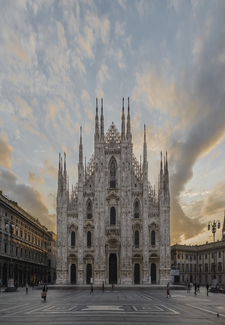

In [ ]:
resizedImages[1]

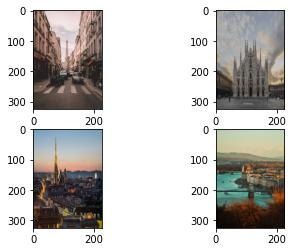

In [ ]:
import matplotlib.pyplot as plt


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(resizedImages[0])
axarr[0,1].imshow(resizedImages[1])
axarr[1,0].imshow(resizedImages[2])
axarr[1,1].imshow(resizedImages[3])

In [ ]:
!pip install urlextract
from urlextract import URLExtract

#Fetching resized movie images

In [ ]:
import requests
from PIL import Image
import requests
from io import BytesIO

def get_all_movies_images(imdb):
  extractor = URLExtract() 
  
  url = "https://imdb8.p.rapidapi.com/title/get-images"

  querystring = {"tconst":imdb,"limit":"25"}

  headers = {
      'x-rapidapi-host': "imdb8.p.rapidapi.com",
      'x-rapidapi-key': "7f3de3d2eemsh2291312e476f463p157afbjsn020bbf7037b8"
      }

  response = requests.request("GET", url, headers=headers, params=querystring)
  resizedImages=[]
  for image in set(extractor.find_urls(response.text)):
    try:
      r = requests.get(image)
      img = Image.open(BytesIO(r.content))
      resizedImg = img.resize((225, 230), Image.ANTIALIAS)
      resizedImages.append(resizedImg)
    except:
      pass


  return resizedImages 

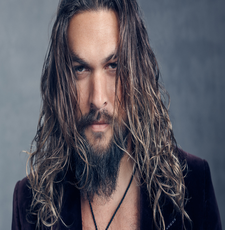

In [ ]:
urls = get_all_movies_images('tt9663764')
# resizedImages =[]
# for image in urls:
#     r = requests.get(image)
#     img = Image.open(BytesIO(r.content))
#     resizedImg = img.resize((225, 325), Image.ANTIALIAS)
#     resizedImages.append(resizedImg)
urls[1]

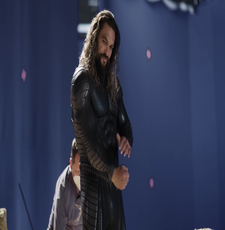

In [ ]:
urls[8]

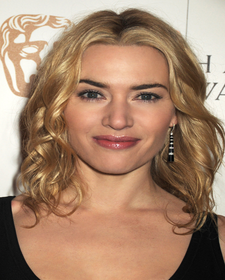

In [ ]:
resizedImages[10]

to make the baground trasparent make hex code to rgb value and then change alpha value (0 - 1)

In [ ]:
"https://www.rapidtables.com/convert/color/hex-to-rgb.html"

#online convertor

'https://www.rapidtables.com/convert/color/hex-to-rgb.html'

In [ ]:
element {
    background: rgba(red, green, blue, alpha);
    // CSS property
}

div.first {
                /*setting alpha = 0.1*/
                background: rgba(0, 151, 19, 0.1);
            }

css alignments and font and trasparent


In [ ]:
st.markdown(
    """
<style>
.reportview-container .markdown-text-container {
    font-family: monospace;
}
.sidebar .sidebar-content {
    background-image: linear-gradient(#2e7bcf,#2e7bcf);
    color: white;
}
.Widget>label {
    color: white;
    font-family: monospace;
}
[class^="st-b"]  {
    color: white;
    font-family: monospace;
}
.st-bb {
    background-color: transparent;
}
.st-at {
    background-color: #0c0080;
}
footer {
    font-family: monospace;
}
.reportview-container .main footer, .reportview-container .main footer a {
    color: #0c0080;
}
header .decoration {
    background-image: none;
}

</style>
""",
    unsafe_allow_html=True,
)

In [ ]:
id = 'tt1630029'

In [ ]:
import pandas as pd
link = f"https://www.imdb.com/title/{id}/ratings/?ref_=tt_ov_rt"
data = pd.read_html(link, header=0)[1]
data


In [ ]:
import urllib
import bs4 as bs
def get_reviews(imdb_id):
  if imdb_id:
    url = f'https://www.imdb.com/title/{imdb_id}/reviews?ref_=tt_ov_rt'

    sauce = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(sauce,'lxml')
    soup_result = soup.find_all("div",{"class":"text show-more__control"})
    reviews = []
    for i in range(len(soup_result)):
      reviews.append(soup_result[i].text)

    full_reviews = pd.DataFrame(reviews,  columns=['reviews'])
    return full_reviews

In [ ]:
imdb_id = 'tt1630029'
len(get_reviews(imdb_id))



0

In [ ]:
|